
   # Bias Variance Tradeoff


## Part One - Necessary Code

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

In [2]:
# Colors
nemo = "#FF4A11"
granite = "#252629"
blue = "#33A5FF"
green = "#03AC13"

### Generate Data

In [3]:
def generate_data(num_points):
    np.random.seed(42)
    x = np.random.uniform(low=0, high=12, size=num_points)
    noise = np.random.normal(loc=0, scale=1, size=num_points)
    y = 0.3 + 0.5 * x + noise
    X = np.column_stack((np.ones(num_points), x))
    X_df = pd.DataFrame(X, columns=['intercept', 'Week of bootcamp'])
    X_df['Coffee consumption in [l]'] = y
    return X_df, X, y.reshape(-1, 1)

num_points=50
data, X, y = generate_data(num_points)

In [4]:
# Plot the data points
def plot_data(data, color=blue, color_line=nemo, figsize=(10,6), regression=True, residuals=False):
    data_plot = data.copy()
    plt.figure(figsize=figsize)
    sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 2.})
    plt.scatter(data_plot['Week of bootcamp'], data_plot['Coffee consumption in [l]'], c=color, s=30, zorder=3)
    
    # Add regression line
    if regression:
        b1, b0 = np.polyfit(data_plot['Week of bootcamp'], data_plot['Coffee consumption in [l]'], 1)
        data_plot['Regression line'] = b0 + b1*data_plot['Week of bootcamp']
        plt.plot(data_plot['Week of bootcamp'],  data_plot['Regression line'], c=color_line, zorder=2)
        if residuals:
            for index, row in data_plot.iterrows():
                plt.plot([row['Week of bootcamp'], row['Week of bootcamp']], [row['Coffee consumption in [l]'], row['Regression line']], color=granite, linewidth=1, zorder=1)
        
    plt.xlabel('Week of bootcamp')
    plt.ylabel('Coffee consumption [l]')
    sns.despine()

### Error Analysis

This example is from [notebook 1 of the predictive regression repo](https://github.com/neuefische/ds-predictive-regression/blob/main/1_Bias_Variance_Tradeoff.ipynb). Therefore, it is different data than the coffee/bootcamp time dataset we created for the rest of the plots.

In [5]:
def lin_reg_model_for_error_analysis():
    """creating data and linear regression model for error analysis plot. Data is created with x^3, the model is a simple linear regression, so that a pattern can be seen in the residual plot.

    Returns:
        y_test: test data that was created
        y_pred_test : predictions of the simple linear regression model for the test data
    """
    RSEED = 12
    np.random.seed(4)
    # generating 100 random x-values between -7 and 7
    x = np.random.uniform(-7,7,size=100)
    # adding some random noise with np.random.normal with mu = 0 and std = 20
    y = 10 * x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(0, 20, 100)
    # transforming the data to include another axis since this is expected for modelling with scikit-learn
    x = x[:, np.newaxis]
    y = y[:, np.newaxis]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=RSEED) 
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred_test = lin_reg.predict(X_test)
    
    return y_test, y_pred_test

def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color=nemo, alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color=granite)
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim(-350, 150)
    ax[0].set_ylim(-350, 150)
    
    ax[1].scatter(y_pred_test, residuals, color=nemo, alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color=granite)
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

### Learning Curves

In [6]:
# Learning curves data
np.random.seed(42)

m = 100
X_learning_curve = 6 * np.random.rand(m, 1) - 3
y_learning_curve = 0.5 * X_learning_curve**2 + X_learning_curve + 2 + np.random.randn(m, 1)

lin_reg = LinearRegression()
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

In [7]:
def plot_learning_curves(model, X, y, title, figsize=(10,6), ax=None, y_label=None):
    if ax==None:
        plt.figure(figsize=figsize)
    else:
        plt.gca()
    
    sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.})
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, test_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))

    ax.plot(np.sqrt(train_errors), "-", c=nemo, linewidth=2, label="train")
    ax.plot(np.sqrt(test_errors), "--", c=granite, linewidth=3, label="test")
    ax.legend(loc="upper right", fontsize=14)  
    ax.set_ylim(0, 3)
    ax.set_xlim(0, 80)
    ax.set_xlabel("Training set size", fontsize=14) 
    ax.set_title(title)
    if y_label:
        ax.set_ylabel("RMSE")
    sns.despine()

## Part two - Lecture

<div class="slide-title"> 
    
# Bias Variance Tradeoff
 

    
</div>
    
###### ... and regularization

## Let's start with IceCream
<br>
<div class="images">
 <img src="../images/bias_variance_tradeoff/bv_transparent.jpg" width=1000 heigth=1000 align="middle">
 
</div>

Notes: Imagine we measure the sunshine hours and the Ice cream consumption of a bunch of spiced people and plotted on a graph

People tend to eat less ice creams when there is less sunshine hours, more ice creams when there more sunshine ours, but upper a certain sunshine hours people don't eat even more icecream

## Let's start with IceCream
<br>
<div class="images">
 <img src="../images/bias_variance_tradeoff/bv_transparent_x.jpg" width=1000 heigth=1000 align="middle">
 
</div>

Notes: Given the data we would like to predict the icecream consumption given  the sunshine hours. 

if you told me that there are that many sunshine hours (x letter on x axis), then we might predict that the people will consume that amount (x letter on y axis) of icecream. 

### Visual Approach
<div class="group">
  <div class="text">   
<img src="../images/bias_variance_tradeoff/train_test_bv_1_transparent_bg.png">
    </div>
      <div class="images">
    </div>
</div>

Notes: Ideally we would know the exact mathematical formula that describes the relationship between sunshine hours and icecream consumption (gray line in theplot). 

But in this case we don't know the formula, so we are going to use two machine learning methods to approximate this relationship

## Why is it necessary to split the data into train and test?

<div class="group">
  <div class="text">   


Data is typically split into a train and a test set.
* to **evaluate how the model performs** on unseen data <br> i.e. if the model ‘generalises’ well
      <p>
* typical splits are **70% train data** (or more)  and **30% test** data (or less)
      <p>
* sometimes an additional **validation set** is used
    </div>
    <div class="images">
        <img src="../images/bias_variance_tradeoff/train_test_bv_2_transparent_bg.png">
    </div>
</div>

[Read more on splitting](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=The%20train%2Dtest%20split%20is,dividing%20it%20into%20two%20subsets)


Notes: The first thing we do is split the data in two sets, one for training the machine learning algorithms and one for testing them.

simplest: split the dataset in train and test (randomly) and/or validation the split depends on the size of your dataset more train data -> better model use as much test and validation as you can afford from 30% to only 5% random splitting the data might not be random enough - one should check for i.i.d (checking distributions of train target var vs test target variables) if there are differences in distribution of features then you might need to do stratified sampling (for example for gender or age.. )

### Simple  Model
<div class="group">
  <div class="text">   
<img src="../images/bias_variance_tradeoff/train_test_bv_3_transparent_bg.png">
    </div>

Notes: The first ML model we use is LinearRegression. This model fits a Straight Line to the training set.

The Straight line doesn't have the flexibility to accurately replicate the arc in the true Relationship. No Matter how we try to fit the line, it will never curve.

Thus, the Straight line will never capture the true relationship between sunshine hours and ice cream consumption. (This inability is called bias). Because the Straight line cannot be curved like the true relationship it has a relatively large amount of bias.

### Complex  Model
<div class="images">
        <img src="../images/bias_variance_tradeoff/train_test_bv_4_transparent_bg.png">
    </div>

Notes: Another ML model might fit a Squiggly line to the training set 

The __Squiggly line__ is so __flexible__ that can embrace the training set. 

Because the Squiggle line can handle the arc in the true relationship, it has very little bias. 

__Which model would you prefer?__

### Train Data Residuals
<div class="group">
  <div class="text">   
<img src="../images/bias_variance_tradeoff/train_test_bv_5_transparent_bg.png">
    </div>
      <div class="images">
        <img src="../images/bias_variance_tradeoff/train_test_bv_6_transparent_bg.png">
    </div>
</div>

Notes: We can compare how well the __Straight line__ and the __Squiggle line__ fit the training set by calculating their sums 

We measure the distances from the fit lines to the data, square them (squared so that the negative distances do not cancel out the positive distances) and add them up.


Notice how the __Squiggle line__ fits the data so well that the distances between the fitting line and the data are all __0__


In the context to see  whether the __Straight line__ fits the training data better than the __Squiggle line__, the Squiggle line wins.


But remember, so far we have only calculated the sum of squares for the training set

### Test Data Residuals
<div class="group">
  <div class="text">   
<img src="../images/bias_variance_tradeoff/train_test_bv_8_transparent_bg.png">
    </div>
      <div class="images">
        <img src="../images/bias_variance_tradeoff/train_test_bv_7_transparent_bg.png">
    </div>
</div>

Notes: We also have a testing set. Now let's calculate the sum of squares for the test set. 

The __Straight line__ wins.

Even though the Squiggle line did a great job fitting the training set (low bias: it is flexible enough that can adapt to the curve in the relatiuonship), it did a terrible job on testing set. 

__The Squiggly Line has high variability because results in vastly different sums of squares for different dataset.__

__In other words, it is hard to predict how well the Squiggly Line will perform  with future datasets. It might do well sometimes and other times it migght do terribly__

## Machine Learning Terminology
<div class="group">
  <div class="text">   
<img src="../images/bias_variance_tradeoff/train_test_bv_3_transparent_bg.png">
      
Too simple model:
* high bias
* under-fits the data
* <font color = "lightgrey">low variance</font>
* <font color = "lightgrey">generalizes better on new data</font>
</div>
      <div class="images">
        <img src="../images/bias_variance_tradeoff/train_test_bv_4_transparent_bg.png">
          
Too complex model:
* low bias
* over-fits the data
* <font color = "lightgrey">high variance</font>
* <font color = "lightgrey">generalizes bad on new data</font>         
    </div>
</div>


Notes:

__High bias__ --> Straight line Cannot capture the underlying true relationship between sunshine hours and ice cream consumption. <-- __Underfit__


__Low Bias__ --> Squiggle line fits the training data very well but not the testing set <-- __Overfitting__

### Machine Learning Terminology
<div class="group">
  <div class="text">   
<img src="../images/bias_variance_tradeoff/train_test_bv_8_transparent_bg.png">

Too simple model:
* <font color = "lightgrey">high bias</font>
* <font color = "lightgrey">under-fits the data</font> 
* low variance
* generalizes better on new data
    </div>
      <div class="images">
        <img src="../images/bias_variance_tradeoff/train_test_bv_7_transparent_bg.png">

Too complex model: 
* <font color = "lightgrey">low bias</font>
* <font color = "lightgrey">over-fits the data</font> 
* high variance
* generalizes bad on new data
    </div>
</div>

Notes:

__Low variance__ --> Straight line: the sums ofsquares are very similar. It might only give good predictions, and not great predictions but they will be consistently good predictions

__high variance__ --> Squiggly line has high variability on different datasets. It might do well sometimes and other times very terribly


Ideal algorithm has Low Bias and can accurately model the true relatioship and it has low variability by producing consistent prediction across different datasets.

## Loss and Cost functions 

**Loss function**

The loss function quantifies how much a model $f$‘s prediction   $\hat{y}=f(x)$ deviates from the ground truth $y=y(x)$ for one particular object $\mathbf{x}$.
 



So, when we calculate loss, we do it for a **single object** in the training or test sets. There are many different loss functions we can choose from, and each has its advantages and shortcomings. In general, any **distance metric** defined over the space of target values can act as a loss function. 



**Cost function**

The cost function measures the model’s **error on a group of objects**. So, if L is our loss function, then we calculate the cost function by aggregating the loss L over the training, validation, or test data. 

## Linear Regression

<div class="group">
  <div class="text">    
      
MSE (mean squared errors) here is an example of a **cost function** - we've aggregated the loss of individual predictions into a single value we can use to gauge the quality of our model.   
    </div>
      <div class="images">
      
$$\begin{align}
\hat{y} &= b_{0}+b_{1}x_{1}+\text{...}+b_{m}x_{m}\\[8pt]
e &= y-\hat{y}\\[12pt]
\text{MSE} &= {\frac{1}{n}}\sum_{i=1}^{n}{(y_{i}-{\hat{y}}_{i})}^{2}
\end{align}$$
</div>
</div>

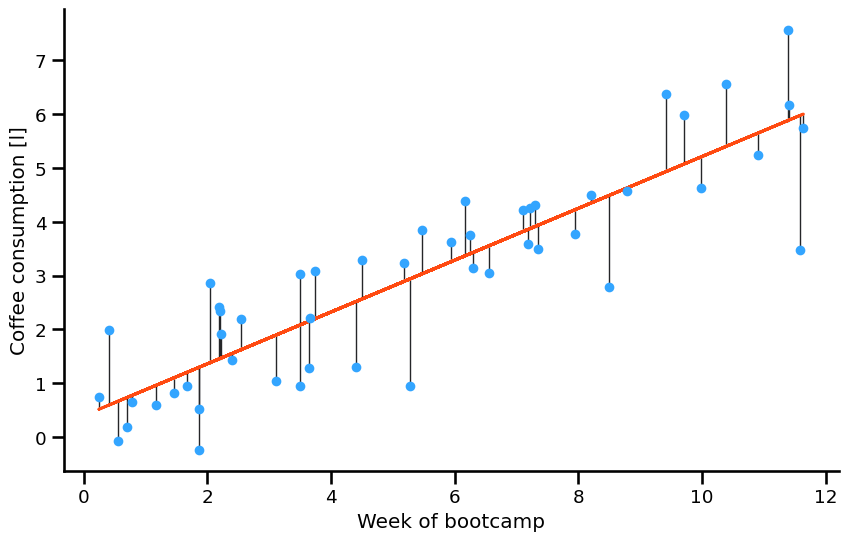

In [8]:
plot_data(data, residuals=True)

Notes: objective is to minimize residuals (e) via cost function MSE


### Optimal model and prediction for linear regression


$$\begin{align} 
y&=f(x)=\beta_{0}+\beta_{1}x+\epsilon \\[5pt]
\hat{y} &= b_{0}+b_{1}x_{1}+\text{...}+b_{m}x_{m}
\end{align}$$

In frequentist statistics, we make a point estimate of beta depending on the dataset D


## Estimators

<div class="group">
  <div class="text">   

Different kinds of estimators
* Point estimators (e.g. mean, regression parameters)
* Interval estimators (e.g. confidence bands)

An “estimator” or point estimate is a statistic (a function of the data) that is used to infer the value of an unknown parameter in a statistical model.
    </div>
    <div class="images">
        <img src="../images/bias_variance_tradeoff/point_interval_estimates_transparent_bg.png">
    </div>
</div>

### Estimators
Assumption for estimators
<ul>
<li> <b>Dependent</b> on the data:
<br>Different datasets give different estimation values<br> 
    
$$\hat{y}(x,\;{\cal D})\;\;\;\;\;{\cal D}=\{\left(x_{1},\;y_{1}\right), \text{...}, (x_{n},\;y_{n})\}$$
    
</li>

<li> Data is considered to be <b>statistically random</b>
<br>No recognizable patterns or regularities </li>

<li> Parameters are <b>considered to be fixed</b><br> 
Data Generating Process (DGP):    

$$y=f(x)=\beta_{0}+\beta_{1}x+\epsilon$$
 
</li>
</ul>

Notes: DGP: Data generating process The DGP is the process that cause data to occur. The DGP is a Platonic ideal that we do not and cannot know. Only in simulations can we define a mathematical DGP, in the real world they are hidden from us. example dice throw in a ideal world easy to simulate in reality a lot of influences, temperature, how hard the dice is thrown, air pressure, form of the dice etc surveys or qPCR epsilon is error that we can't change e.g. pipetting error

## Estimates
<div class="group">
  <div class="text">   
      
* We rarely have money/resources to measure everything     
* So we will have **samples of the population** which we hope to be representative of the whole population     
* The **more data** we have the **more confident** we are in the estimates     
* Ideally: the results drawn from our experiments are reproducible

In Data Science most metrics omit the word “estimate”, nevertheless **most of the
metrics we use are estimates**
    </div>
    <div class="images">
        <img src="../images/bias_variance_tradeoff/img_p13_2.png">
    </div>
</div>

## Mean Square Error

$$\text{MSE}(\hat{y}) = E\big[(\hat{y}\;(x,\;{\cal D})-f(x))^{2}\big]$$

Mean Square Error is defined as the **expected value of the squared errors**

E - expected value of a random variable is a generalization of the weighted average


Notes: Expected value example: Dice roll -> ⅙ * 1 + ⅙ * 2 + ⅙ * 3 + ⅙ * 4 + ⅙ * 5 + ⅙ * 6 = 3.5

## Error Decomposition

$$\begin{align}
\text{MSE}(\hat{y})&=\big(E(\hat{y}-f(x))\big)^2 + E\big[(\hat{y}-E[\hat{y}])^2\big] + \sigma_{e}^2 \\[10pt]
\text{Bias}(\hat{y})^2&=\big(E(\hat{y}-f(x))\big)^2 \\[6pt]
\text{Variance}(\hat{y})&=E\big[(\hat{y}-E[\hat{y}])^2\big] \\[6pt]
\text{Irreducible Error}&=\sigma_{e}
\end{align}$$






[Example](https://www.countbayesie.com/blog/2019/1/30/a-deeper-look-at-mean-squared-error)



Notes: The variance of a random variable X is the expected value of the squared deviation from the mean bias: expected value of the difference between our estimator and the true value f(x) = y high variance, higher difference between the expected and the values. more detailed math: https://towardsdatascience.com/mse-and-bias-variance-decomposition-77449dd2ff55

### Error Decomposition

$$Bias^2 + Variance + Noise$$

$$\underbrace{Bias^2}_{underfitting} + \underbrace{Variance}_{overfitting} + \underbrace{Noise}_{unpredictable}$$

### Bias

**Bias**: simplifying assumptions made by a model to make the target function easier to learn. ("How far away are the decisions from the data.")
* **Underfitting** the training data
* **Making assumptions** without caring about the data
* Model is **not complex** enough 

Linear algorithms tend to have high bias, this makes them fast to learn and easier to understand but less flexible.



Notes: Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

### Variance
Variance is the amount that the estimate of the target will change if different training data was used. 

How sensitive is the algorithm to the specific training data used.
* **Overfitting** the training data
* Being **extremely perceptive** of the training data
* Model is **too complex**


## The Bias-Variance-Tradeoff

<div class="group">
  <div class="text">   

<img src="../images/bias_variance_tradeoff/model_complexity_transparent_bg.png">
    </div>
    <div class="images">
<br>
<br>       
     
$$\frac{d\,Bias^{2}}{d\,Complexity}=-\frac{d\,Variance}{d\,Complexity}$$
        
</div>
</div>

Notes: If our model is too simple and has very few parameters then it may have high bias and low variance. On the other hand if our model has large number of parameters then it’s going to have high variance and low bias. So we need to find the right/good balance without overfitting and underfitting the data. This tradeoff in complexity is why there is a tradeoff between bias and variance. An algorithm can’t be more complex and less complex at the same time.

### Bulls-eye - a model that predicts perfectly

<div class="group">
  <div class="text">   

<img src="../images/bias_variance_tradeoff/img_p21_1.png">
    </div>
    <div class="images">
Do you want a clock that is sometimes 10 mins late or a clock that is always 10 mins late?
    </div>
</div>


Notes: Each dot is the evaluation result of a whole experiment.. and not the residual of one observation; Variance indicates how far the collection of estimates are from the expected values of the estimates .. on average Bias of an estimator is the distance between the average of the collection of estimates and the parameter being estimated. In the above diagram, center of the target is a model that perfectly predicts correct values. As we move away from the bulls-eye our predictions get worse and worse. We can repeat our process of model building to get separate hits on the target. high bias low variance = underfitting (low left) low bias high variance = overfitting (upper right)

### Desirable properties of estimators

<div class="group">
  <div class="text">   
      
Minimum variance estimators
* Prevent overfitting 
      
Unbiased estimators
* Prevent underfitting

A model as simple as possible

“A simple model is the best model” - Occam’s Razor
    </div>
    <div class="images">
<img src="../images/bias_variance_tradeoff/img_p23_1.png">
    </div>
</div>


## Error Analysis

The EDA for the errors your model makes
* comparing the errors on test / train / validation
    * expecting them to be close
    * low error on train but high on validation is a clear sign of overfitting
* plotting residuals
    * expecting no pattern
    * pattern in residual plots are a sign for underfitting => your model is not complex enough
    
[Analyzing residuals](https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/)

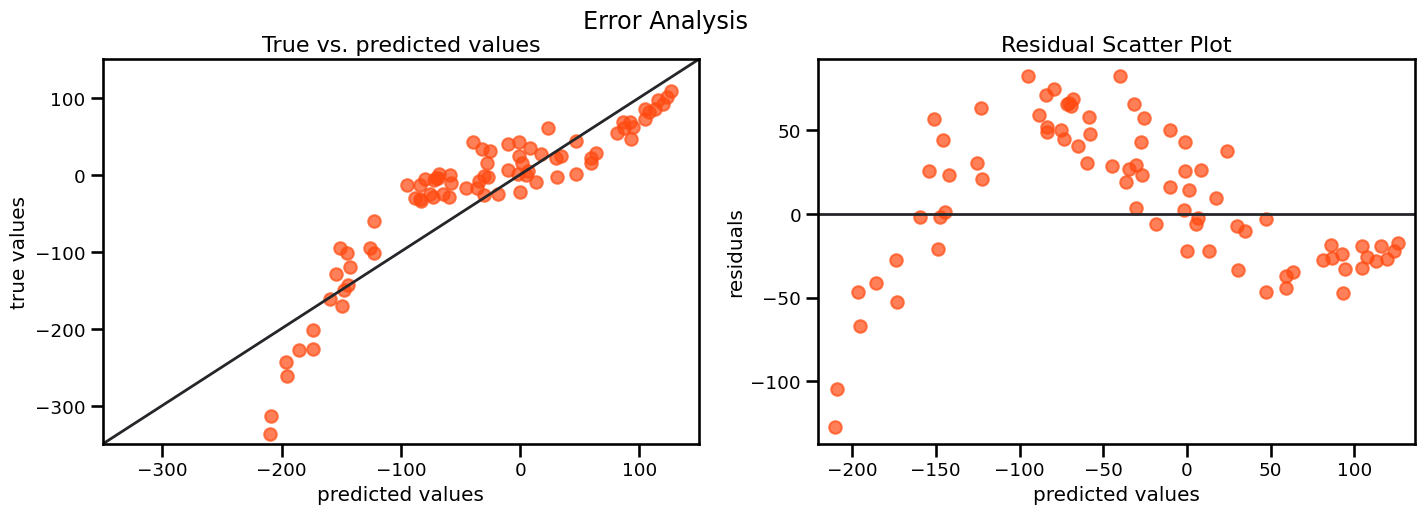

In [9]:
error_analysis(*lin_reg_model_for_error_analysis())

## Learning Curves - underfitting
Model Performance (training and validation) against an increasing set of training data
* Start: Training loss is low, generalization is very bad
* Adding more data: Both are very close and at a high level

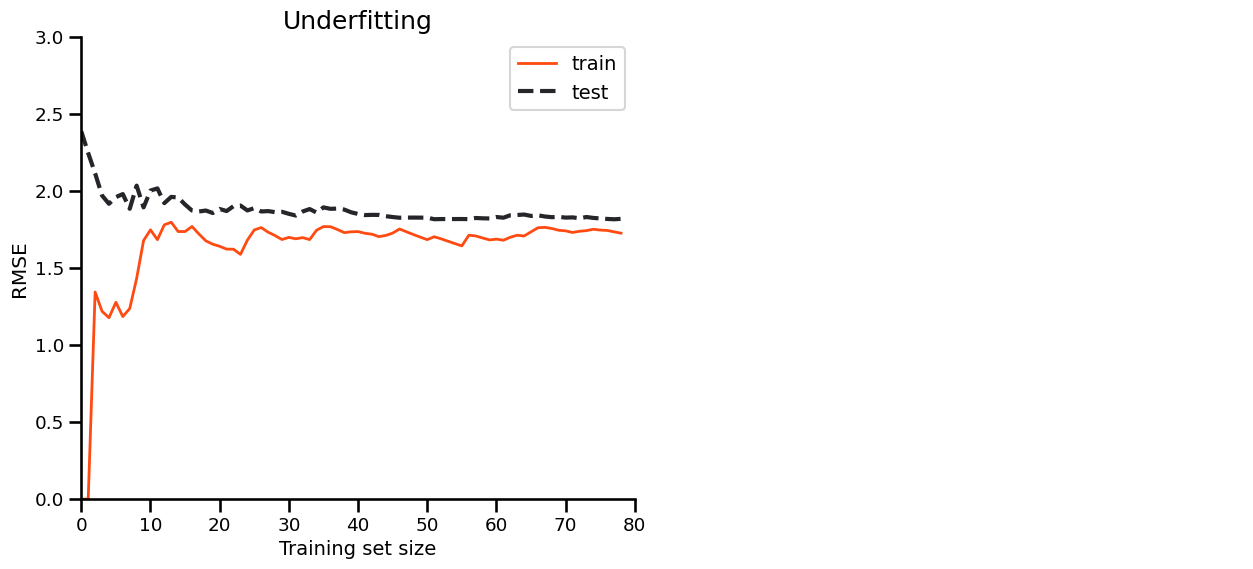

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
plot_learning_curves(lin_reg, X_learning_curve, y_learning_curve, title="Underfitting", ax=ax[0], y_label=True)
ax[1].axis('off')
plt.subplots_adjust(wspace=0.1);

Notes: RMSE higher, distance lower

### Learning Curves - overfitting

Model Performance (training and validation) against an increasing set of training data
* Training error is much lower
* There is a gap: validation error is way higher than training error

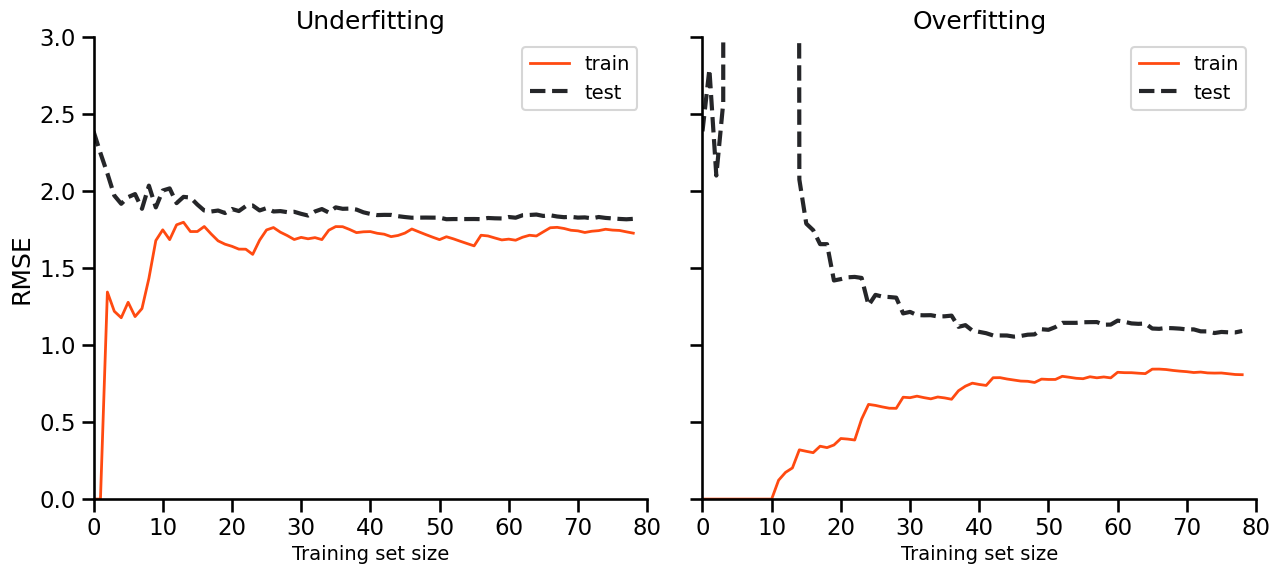

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
plot_learning_curves(lin_reg, X_learning_curve, y_learning_curve, title="Underfitting", ax=ax[0], y_label=True)
plot_learning_curves(polynomial_regression, X_learning_curve, y_learning_curve,  title="Overfitting", ax=ax[1])
plt.subplots_adjust(wspace=0.1);

Notes: RMSE lower, distance higher

## Bias vs. Variance

<div class="group">
  <div class="text">   
      
**High Bias**: 

more assumptions of the target function
* Linear Regression, Linear Discriminant Analysis, Logistic Regression

**High Variance**: 
      
large changes to the estimate when train data changed
* Decision Trees, K-Nearest Neighbors, SVM

</div>
<div class="images">
       
**Low Bias**: 

fewer assumptions about the target function
* Decision Trees, K-Nearest Neighbors, SVM
      
**Low Variance**: 
    
small changes to the estimate when the train data changes
* Linear Regression, Linear Discriminant Analysis, Logistic Regression
  </div>
</div>

## Overfitting vs. Underfitting

<div class="group">
  <div class="text">   
      
**Overfitting**: 
* Reduce the complexity of the model
* Get more data
* Regularize the model
</div>
<div class="images">
       
**Underfitting**:
* Bring in a better model
* Feature engineering
* Ease regularization parameters
  </div>
</div>

## Can you solve this little riddle?

$$\begin{align}
f(1)&=1 \\
f(2)&=3 \\
f(3)&=5 \\
f(4)&=7 \\
f(5)&=??? \\
\end{align}$$



Notes: most guess 2x-1

### It’s obvious, isn’t it?

$$f(5)=217341$$


Notes: is this under or over fitting

### At least if you apply this function

$$ f(x)=\frac{1811}{2}x^{4}-90555x^{3}+\frac{633885}{2}x^{2}-452773x+217331$$

This is a nice example taken from University of Berkeley to showcase how you can under do it when it comes to fitting a model.

What kind of error have you done with your personal model?

## Resources
[Hands-on ML with scikit-learn and TensorFlow, Geron](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291), Geron

http://scott.fortmann-roe.com/docs/BiasVariance.html

https://medium.com/analytics-vidhya/bias-variance-tradeoff-for-dummies-9f13147ab7d0

Machine Learning - A probabilistic Perspective - Kevin P. Murphy

https://explained.ai/regularization/constraints.html

https://explained.ai/statspeak/index.html



